# Stationary SCM and DAG (IND.) from figure 3(b) in paper

In this notebook we investigate the one SCM where DCBO was not the most succesful method. 

In [21]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_ind_scm
from src.utils.sem_utils.toy_sems import StationaryIndependentSEM as IndSEM
from src.utils.sem_utils.sem_estimate import auto_sem_hat
from src.experimental.experiments import run_methods_replicates

from numpy.random import seed
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem setup

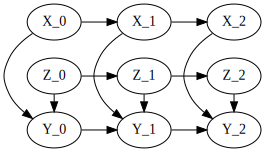

In [2]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_ind_scm(T=T)
dag_view

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [3]:
type(dag)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [4]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Y_0; Z_0 -> Y_0; X_1 -> Y_1; Z_1 -> Y_1; X_2 -> Y_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }


Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

## Other setup parameters 

In [5]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 20

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = -2.007', 'y^*_1 = -4.013', 'y^*_2 = -6.02']


## Explore optimization methods

Unlike the demo in `stat_scm.ipynb` here we are going to demonstrate the replicate method as used to generate the results in the paper. In all these examples we do not employ any interventional data, just observational.

In [22]:
# See method for argument details
R = 5
results = run_methods_replicates(G=dag, 
                                sem=IndSEM, 
                                make_sem_estimator=auto_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=True)

Experiment count:   0%|          | 0/5 [00:00<?, ?it/s]


	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.033408074549503
Optimization restart 1/1, f = 1.5930373574835772
Optimization restart 1/1, f = 3.3147975254530833


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.0930713514917807
Optimization restart 1/1, f = 5.025110086269165
Optimization restart 1/1, f = 3.0901361843444013
Optimization restart 1/1, f = -1.1459032380399838
Optimization restart 1/1, f = -5.780086979154066
Optimization restart 1/1, f = -9.404614984725448
Optimization restart 1/1, f = -8.25797447547172
Optimization restart 1/1, f = -12.17058857761035
Optimization restart 1/1, f = -16.715163482199053
Optimization restart 1/1, f = 6.660609651677545
Optimization restart 1/1, f = 4.604914994031306
Optimization restart 1/1, f = 4.899157679633926


Optimization restart 1/1, f = 5.147751793966135


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.2628984301351425
Optimization restart 1/1, f = 6.329886160470064
Optimization restart 1/1, f = 3.9095928383034257
Optimization restart 1/1, f = 6.861003555131029
Optimization restart 1/1, f = 6.046738160296215
Optimization restart 1/1, f = 7.799428087717748
Optimization restart 1/1, f = 7.484023949407417
Optimization restart 1/1, f = 9.541557765273005
Optimization restart 1/1, f = 10.840725534380692
Optimization restart 1/1, f = 10.366897686384133
Optimization restart 1/1, f = 6.099497539617124
Optimization restart 1/1, f = 1.9184460280431705
Optimization restart 1/1, f = -2.6404154423937585
Optimization restart 1/1, f = -7.218397768282339
Optimization restart 1/1, f = -11.942887471560146


Optimization restart 1/1, f = -16.681551160566574


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 2.3724971441980416
Optimization restart 1/1, f = 2.6563049439292516
Optimization restart 1/1, f = 4.973799104395642
Optimization restart 1/1, f = 4.67627389599253
Optimization restart 1/1, f = 7.517708251551812
Optimization restart 1/1, f = 6.005299697046906
Optimization restart 1/1, f = 6.391730137288027
Optimization restart 1/1, f = 5.374596663795906
Optimization restart 1/1, f = 8.319318170046602
Optimization restart 1/1, f = 9.540985092744585
Optimization restart 1/1, f = 10.697200928833675
Optimization restart 1/1, f = 11.672811942741784
Optimization restart 1/1, f = 12.083103389791345
Optimization restart 1/1, f = 13.197316117324524
Optimization restart 1/1, f = 14.159688691666187


Time index: 100%|██████████| 3/3 [00:39<00:00, 13.30s/it]

Optimization restart 1/1, f = 14.700849082322174

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.5187341742245208
Optimization restart 1/1, f = -0.2504631046890855
Optimization restart 1/1, f = 7.183125151014731
Optimization restart 1/1, f = 8.830039574498446
Optimization restart 1/1, f = 9.79941194960207
Optimization restart 1/1, f = 10.74253852888659
Optimization restart 1/1, f = 11.549808855486589
Optimization restart 1/1, f = 12.984664619498226
Optimization restart 1/1, f = 13.743675226117743
Optimization restart 1/1, f = 14.801310396379249
Optimization restart 1/1, f = 15.486143329027016


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 16.121947387083917
Optimization restart 1/1, f = 16.71235113887914
Optimization restart 1/1, f = 17.261624540855912
Optimization restart 1/1, f = 17.78684305897746
Optimization restart 1/1, f = 18.26104924187431
Optimization restart 1/1, f = 18.70003999052374
Optimization restart 1/1, f = 19.567815124868964
Optimization restart 1/1, f = 19.97196352838712
Optimization restart 1/1, f = 14.16103681524458
Optimization restart 1/1, f = 18.295289412362216
Optimization restart 1/1, f = 20.029493676970148
Optimization restart 1/1, f = 20.227915257069668
Optimization restart 1/1, f = 20.878089350578733
Optimization restart 1/1, f = 18.498616303398915
Optimization restart 1/1, f = 20.016258875488436
Optimization restart 1/1, f = 21.86155110532204
Optimization restart 1/1, f = 22.229455791228407
Optimization restart 1/1, f = 19.950715148937547
Optimization restart 1/1, f = 20.57457020042969


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 20.73320939954897
Optimization restart 1/1, f = 21.98615462964253
Optimization restart 1/1, f = 23.572532409198686
Optimization restart 1/1, f = 24.357230061557875
Optimization restart 1/1, f = 25.045145585575103
Optimization restart 1/1, f = 26.6710072798492
Optimization restart 1/1, f = 27.593542177731926
Optimization restart 1/1, f = 28.315260699184023
Optimization restart 1/1, f = 35.50040760191808
Optimization restart 1/1, f = 35.88593638691318
Optimization restart 1/1, f = 36.66077335922327
Optimization restart 1/1, f = 36.789220075337404
Optimization restart 1/1, f = 37.117857554128626
Optimization restart 1/1, f = 37.77124144234281
Optimization restart 1/1, f = 38.40293340628592
Optimization restart 1/1, f = 38.31414394335275
Optimization restart 1/1, f = 40.82088546967752
Optimization restart 1/1, f = 42.40887311219218
Optimization restart 1/1, f = 44.204047360230604
Optimization restart 1/1, f = 44.755119689302504
Optimization restart 1/1, f = 45

Time index: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

Optimization restart 1/1, f = 52.0054481926993

	>>>BO




reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.5187341742245208
Optimization restart 1/1, f = -0.2504631046890855
Optimization restart 1/1, f = 7.183125151014731
Optimization restart 1/1, f = 8.830039574498446
Optimization restart 1/1, f = 9.79941194960207
Optimization restart 1/1, f = 10.74253852888659
Optimization restart 1/1, f = 11.549808855486589
Optimization restart 1/1, f = 12.984664619498226
Optimization restart 1/1, f = 13.743675226117743
Optimization restart 1/1, f = 14.801310396379249
Optimization restart 1/1, f = 15.486143329027016
Optimization restart 1/1, f = 16.121947387083917


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 16.71235113887914
Optimization restart 1/1, f = 17.261624540855912
Optimization restart 1/1, f = 17.78684305897746
Optimization restart 1/1, f = 18.26104924187431
Optimization restart 1/1, f = 18.70003999052374
Optimization restart 1/1, f = 19.567815124868964
Optimization restart 1/1, f = 19.97196352838712
Optimization restart 1/1, f = 1.9232014401563942
Optimization restart 1/1, f = 1.2813454783990457
Optimization restart 1/1, f = 1.1588551094026676
Optimization restart 1/1, f = 8.643475266511238
Optimization restart 1/1, f = 8.995297921670915
Optimization restart 1/1, f = 9.69777100044301
Optimization restart 1/1, f = 10.856057522633261
Optimization restart 1/1, f = 10.85399791552122
Optimization restart 1/1, f = 16.558187201193125
Optimization restart 1/1, f = 15.696027885606142
Optimization restart 1/1, f = 16.711276733170163
Optimization restart 1/1, f = 19.477769979988857
Optimization restart 1/1, f = 20.552475115386784
Optimization restart 1/1, f = 

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 22.260011366045564
Optimization restart 1/1, f = 23.573494659130883
Optimization restart 1/1, f = 23.442552977078087
Optimization restart 1/1, f = 23.45968566718628
Optimization restart 1/1, f = 2.002090855496641
Optimization restart 1/1, f = 4.394987881340465
Optimization restart 1/1, f = 4.749078207524672
Optimization restart 1/1, f = 12.226036943983367
Optimization restart 1/1, f = 12.875628129326211
Optimization restart 1/1, f = 11.903780452853866
Optimization restart 1/1, f = 12.352768433187222
Optimization restart 1/1, f = 15.351241014731936
Optimization restart 1/1, f = 15.818740333285652
Optimization restart 1/1, f = 17.22514152210109
Optimization restart 1/1, f = 17.48521843721312
Optimization restart 1/1, f = 17.410140430415005
Optimization restart 1/1, f = 21.679141352127623


Experiment count:  20%|██        | 1/5 [01:29<05:56, 89.10s/it]

Optimization restart 1/1, f = 22.64061038532636
Optimization restart 1/1, f = 22.79501192103548
Optimization restart 1/1, f = 25.374909967163205
Optimization restart 1/1, f = 25.86971894951059
Optimization restart 1/1, f = 25.980403940249534
Optimization restart 1/1, f = 25.773820125275805

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.188988891008224
Optimization restart 1/1, f = 3.9247489317857616


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.6015818498504144
Optimization restart 1/1, f = 4.0995924369739445
Optimization restart 1/1, f = 4.862236400670563
Optimization restart 1/1, f = 4.9666653121217745
Optimization restart 1/1, f = 4.543713483828471
Optimization restart 1/1, f = 4.571617019597332
Optimization restart 1/1, f = 5.469044385730612
Optimization restart 1/1, f = 8.03722248838231
Optimization restart 1/1, f = 8.434652225670693
Optimization restart 1/1, f = 8.68224663049294
Optimization restart 1/1, f = 8.265028652318472
Optimization restart 1/1, f = 7.852930376745126
Optimization restart 1/1, f = 7.167592500945077


Optimization restart 1/1, f = 7.326948539497753


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 5.764687528434171
Optimization restart 1/1, f = 6.9199831425022404
Optimization restart 1/1, f = 4.436264402111793
Optimization restart 1/1, f = 4.856611516324393
Optimization restart 1/1, f = 6.182920575016677
Optimization restart 1/1, f = 8.85161308638627
Optimization restart 1/1, f = 10.086339705075085
Optimization restart 1/1, f = 11.464009230154153
Optimization restart 1/1, f = 8.270166723730593
Optimization restart 1/1, f = 9.999791044947738
Optimization restart 1/1, f = 12.596017684541545
Optimization restart 1/1, f = 14.09104229492007
Optimization restart 1/1, f = 15.624896643720039
Optimization restart 1/1, f = 16.86382356287429
Optimization restart 1/1, f = 18.68120532730864


Optimization restart 1/1, f = 20.05962864987997


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 2.74435763481927
Optimization restart 1/1, f = 4.730383505318814
Optimization restart 1/1, f = 2.1755466090447095
Optimization restart 1/1, f = 4.010263884748474
Optimization restart 1/1, f = 4.274544001221346
Optimization restart 1/1, f = 6.0914841860765705
Optimization restart 1/1, f = 5.625811800818894
Optimization restart 1/1, f = 6.314743159448664
Optimization restart 1/1, f = 2.121032179236472
Optimization restart 1/1, f = -2.4816992425166453
Optimization restart 1/1, f = -2.63159993782405
Optimization restart 1/1, f = -7.309169826002869
Optimization restart 1/1, f = -12.004078679871613
Optimization restart 1/1, f = -16.743549681494628
Optimization restart 1/1, f = -21.475921055520434


Time index: 100%|██████████| 3/3 [00:41<00:00, 13.83s/it]

Optimization restart 1/1, f = -26.241768578952154

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.5247448852414198
Optimization restart 1/1, f = 4.2363483993603595
Optimization restart 1/1, f = 4.448481540408611
Optimization restart 1/1, f = 3.8618296471642495
Optimization restart 1/1, f = 3.5060653002441224
Optimization restart 1/1, f = 2.8074034995130828
Optimization restart 1/1, f = 5.01385430974232
Optimization restart 1/1, f = 3.276349966986518
Optimization restart 1/1, f = -0.7658319266178419

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 8.824073933802708
Optimization restart 1/1, f = 9.28132664863588
Optimization restart 1/1, f = 9.575760353406412
Optimization restart 1/1, f = 10.790091368555522
Optimization restart 1/1, f = 11.225096206618382
Optimization restart 1/1, f = 11.619909843327607
Optimization restart 1/1, f = 11.610655148726474
Optimization restart 1/1, f = 11.534897008537794
Optimization restart 1/1, f = 11.453399259850908
Optimization restart 1/1, f = 11.621780511085923
Optimization restart 1/1, f = 19.35630171140575
Optimization restart 1/1, f = 19.569664961986454
Optimization restart 1/1, f = 22.042758562981938
Optimization restart 1/1, f = 21.474538320740578
Optimization restart 1/1, f = 23.451597563402807
Optimization restart 1/1, f = 23.706739272710966
Optimization restart 1/1, f = 23.70025449837495
Optimization restart 1/1, f = 26.16784109703604
Optimization restart 1/1, f = 27.062046040387475
Optimization restart 1/1, f = 28.780034946470582
Optimization restart 1/1, 

reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 37.6908787687499
Optimization restart 1/1, f = 41.55658462722717
Optimization restart 1/1, f = 42.40491263960223
Optimization restart 1/1, f = 41.537837841005064
Optimization restart 1/1, f = 42.485578872899886
Optimization restart 1/1, f = 43.450143051565604
Optimization restart 1/1, f = 44.72979930816894
Optimization restart 1/1, f = 46.01271762454041
Optimization restart 1/1, f = 47.87447054977296
Optimization restart 1/1, f = 48.79128536886737
Optimization restart 1/1, f = 49.07083471736966
Optimization restart 1/1, f = 49.351018989382595
Optimization restart 1/1, f = 49.726308634167204


Time index: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

Optimization restart 1/1, f = 50.75217639026304
Optimization restart 1/1, f = 47.74772422284014
Optimization restart 1/1, f = 47.57551937160178
Optimization restart 1/1, f = 48.16889381920751
Optimization restart 1/1, f = 48.18083723746871
Optimization restart 1/1, f = 49.2570510650028
Optimization restart 1/1, f = 49.00741301558474

	>>>BO




reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.5247448852414198
Optimization restart 1/1, f = 4.2363483993603595
Optimization restart 1/1, f = 4.448481540408611
Optimization restart 1/1, f = 3.8618296471642495
Optimization restart 1/1, f = 3.5060653002441224
Optimization restart 1/1, f = 2.8074034995130828
Optimization restart 1/1, f = 5.01385430974232
Optimization restart 1/1, f = 3.276349966986518
Optimization restart 1/1, f = -0.7658319266178419

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 8.824073933802708
Optimization restart 1/1, f = 9.28132664863588
Optimization restart 1/1, f = 9.575760353406412
Optimization restart 1/1, f = 10.790091368555522
Optimization restart 1/1, f = 11.225096206618382
Optimization restart 1/1, f = 11.619909843327607
Optimization restart 1/1, f = 11.610655148726474
Optimization restart 1/1, f = 11.534897008537794
Optimization restart 1/1, f = 11.453399259850908
Optimization restart 1/1, f = 11.621780511085923
Optimization restart 1/1, f = 2.4212560649180057
Optimization restart 1/1, f = 1.7251197483230503
Optimization restart 1/1, f = 9.06424417992558
Optimization restart 1/1, f = 10.073913359522193
Optimization restart 1/1, f = 12.45415183519036
Optimization restart 1/1, f = 12.799118571398974
Optimization restart 1/1, f = 14.23530137991914
Optimization restart 1/1, f = 15.690975451433786
Optimization restart 1/1, f = 16.80063913239332
Optimization restart 1/1, f = 18.44774097067846
Optimization restart 1/1, f =

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 20.022958753155795
Optimization restart 1/1, f = 22.524610773353047
Optimization restart 1/1, f = 23.760791009410756
Optimization restart 1/1, f = 1.6363824504356725
Optimization restart 1/1, f = 0.7625950579650711
Optimization restart 1/1, f = 15.26154715793114


 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
Experiment count:  40%|████      | 2/5 [03:07<04:43, 94.48s/it]

Optimization restart 1/1, f = 18.23702099516583
Optimization restart 1/1, f = 21.168249084039314
Optimization restart 1/1, f = 24.083861543770247
Optimization restart 1/1, f = 26.974544615386733
Optimization restart 1/1, f = 29.852743016456454
Optimization restart 1/1, f = 32.84863535826796
Optimization restart 1/1, f = 35.71700093395327
Optimization restart 1/1, f = 38.5668546204367
Optimization restart 1/1, f = 41.41180428351602
Optimization restart 1/1, f = 44.25118592064058
Optimization restart 1/1, f = 47.086278991948134
Optimization restart 1/1, f = 49.91965138861119
Optimization restart 1/1, f = 52.7507659343844
Optimization restart 1/1, f = 55.988636007058766
Optimization restart 1/1, f = 58.810642367529155
Optimization restart 1/1, f = 61.627636046450945

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.9927733853189924
Optimization restart 1/1, f = 1.296248358864223
Optimization restart 1/1, f = 3.398747141652253


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.1696913798255624
Optimization restart 1/1, f = 4.961048013296485
Optimization restart 1/1, f = 4.614042875554116
Optimization restart 1/1, f = 5.6086028203368254
Optimization restart 1/1, f = 5.979544939285532
Optimization restart 1/1, f = 5.954827228071206
Optimization restart 1/1, f = 4.317002145054049
Optimization restart 1/1, f = 1.5859058548458291
Optimization restart 1/1, f = -2.9903519776849414
Optimization restart 1/1, f = -7.674927542874462
Optimization restart 1/1, f = -11.618904087156938
Optimization restart 1/1, f = -16.095668972848074


Optimization restart 1/1, f = -20.635038302983528


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 5.536273995410962
Optimization restart 1/1, f = 5.675248065544311
Optimization restart 1/1, f = 6.194968542960353
Optimization restart 1/1, f = 6.325027888236622
Optimization restart 1/1, f = 8.150331349437078
Optimization restart 1/1, f = 9.11757854337576
Optimization restart 1/1, f = 10.422900690136018
Optimization restart 1/1, f = 7.99948460187671
Optimization restart 1/1, f = 9.088036710668487
Optimization restart 1/1, f = 10.971280124040106
Optimization restart 1/1, f = 12.678583197125441
Optimization restart 1/1, f = 13.765235642993073
Optimization restart 1/1, f = 14.838875781655258
Optimization restart 1/1, f = 15.936539358576324
Optimization restart 1/1, f = 17.33415575900181


Optimization restart 1/1, f = 18.038716776217303


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 2.953137436428319
Optimization restart 1/1, f = 3.406231489730305
Optimization restart 1/1, f = 5.047262862100442
Optimization restart 1/1, f = 5.155334424674022
Optimization restart 1/1, f = 7.699250266999652
Optimization restart 1/1, f = 5.855895441806812
Optimization restart 1/1, f = 7.94482413342798
Optimization restart 1/1, f = 5.9659449044483885
Optimization restart 1/1, f = 6.121235487925969
Optimization restart 1/1, f = 1.6324877125125024
Optimization restart 1/1, f = -2.8672841226267627
Optimization restart 1/1, f = -7.23407896169026
Optimization restart 1/1, f = -11.682208397979243
Optimization restart 1/1, f = -16.10473370509208
Optimization restart 1/1, f = -20.840005713874824


Time index: 100%|██████████| 3/3 [00:40<00:00, 13.54s/it]

Optimization restart 1/1, f = 5.413515290283864

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.4911205913212617
Optimization restart 1/1, f = 3.7849546519476247
Optimization restart 1/1, f = 4.819575873661824
Optimization restart 1/1, f = 5.201864919571612
Optimization restart 1/1, f = 6.952621248031289
Optimization restart 1/1, f = 7.217377716910006
Optimization restart 1/1, f = 7.475079293276561
Optimization restart 1/1, f = 12.234263324033316
Optimization restart 1/1, f = 12.749704604250589
Optimization restart 1/1, f = 13.387527525408487
Optimization restart 1/1, f = 13.864733810840654

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 14.902081752794322
Optimization restart 1/1, f = 15.273202233011606
Optimization restart 1/1, f = 15.570638481573031
Optimization restart 1/1, f = 16.019363948376906
Optimization restart 1/1, f = 16.246604529890213
Optimization restart 1/1, f = 16.515332597882185
Optimization restart 1/1, f = 16.57525753273422
Optimization restart 1/1, f = 16.532600135858026
Optimization restart 1/1, f = 22.98675283488384
Optimization restart 1/1, f = 22.51984908036245
Optimization restart 1/1, f = 26.11449567143052
Optimization restart 1/1, f = 26.398926466329822
Optimization restart 1/1, f = 28.418982828084598
Optimization restart 1/1, f = 28.492680356576198
Optimization restart 1/1, f = 31.121307671924008
Optimization restart 1/1, f = 31.693967117020378
Optimization restart 1/1, f = 32.77284988475011
Optimization restart 1/1, f = 34.364699899028196
Optimization restart 1/1, f = 35.51027101119328
Optimization restart 1/1, f = 35.34565719351364
Optimization restart 1/1, 

reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 39.102244753059445
Optimization restart 1/1, f = 37.1856071008624
Optimization restart 1/1, f = 39.95719652510548
Optimization restart 1/1, f = 41.47746548513233
Optimization restart 1/1, f = 42.606015767936995
Optimization restart 1/1, f = 43.34365296807976
Optimization restart 1/1, f = 45.32702174037315
Optimization restart 1/1, f = 47.03381898369534
Optimization restart 1/1, f = 48.00766682003731
Optimization restart 1/1, f = 49.13429277006947
Optimization restart 1/1, f = 46.82296679138984
Optimization restart 1/1, f = 47.87358073262173
Optimization restart 1/1, f = 48.768811981372544
Optimization restart 1/1, f = 49.83417894372833
Optimization restart 1/1, f = 50.72267862300013
Optimization restart 1/1, f = 51.104927740323454
Optimization restart 1/1, f = 50.979220797318845
Optimization restart 1/1, f = 50.63069778393544
Optimization restart 1/1, f = 50.89619052321443


Time index: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

Optimization restart 1/1, f = 49.77553911693725
Optimization restart 1/1, f = 50.85718540249065

	>>>BO




reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.4911205913212617
Optimization restart 1/1, f = 3.7849546519476247
Optimization restart 1/1, f = 4.819575873661824
Optimization restart 1/1, f = 5.201864919571612
Optimization restart 1/1, f = 6.952621248031289
Optimization restart 1/1, f = 7.217377716910006
Optimization restart 1/1, f = 7.475079293276561
Optimization restart 1/1, f = 12.234263324033316
Optimization restart 1/1, f = 12.749704604250589
Optimization restart 1/1, f = 13.387527525408487
Optimization restart 1/1, f = 13.864733810840654

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 14.902081752794322
Optimization restart 1/1, f = 15.273202233011606
Optimization restart 1/1, f = 15.570638481573031
Optimization restart 1/1, f = 16.019363948376906
Optimization restart 1/1, f = 16.246604529890213
Optimization restart 1/1, f = 16.515332597882185
Optimization restart 1/1, f = 16.57525753273422
Optimization restart 1/1, f = 16.532600135858026
Optimization restart 1/1, f = 1.8526951927487538
Optimization restart 1/1, f = 7.690315148765879
Optimization restart 1/1, f = 9.08620713708614
Optimization restart 1/1, f = 10.111221927700088
Optimization restart 1/1, f = 10.965041132493997
Optimization restart 1/1, f = 14.203239330993075
Optimization restart 1/1, f = 16.042975021268383
Optimization restart 1/1, f = 17.433658595228124
Optimization restart 1/1, f = 19.29614548904263
Optimization restart 1/1, f = 20.884173654154203
Optimization restart 1/1, f = 21.848398841071727
Optimization restart 1/1, f = 22.998368739754063
Optimization restart 1/1

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 21.7253202428956
Optimization restart 1/1, f = 23.28188291482256
Optimization restart 1/1, f = 24.0520736339897
Optimization restart 1/1, f = 24.42235552746071
Optimization restart 1/1, f = 26.991875101021513
Optimization restart 1/1, f = 27.395015142518684
Optimization restart 1/1, f = 3.9512721080207402
Optimization restart 1/1, f = 3.729493369277612
Optimization restart 1/1, f = 3.6227533248426833
Optimization restart 1/1, f = 10.949476833382809
Optimization restart 1/1, f = 11.755009565449118
Optimization restart 1/1, f = 14.747883953257983
Optimization restart 1/1, f = 14.869102175490937
Optimization restart 1/1, f = 15.974184133523053
Optimization restart 1/1, f = 16.279009170642322
Optimization restart 1/1, f = 19.32149245047386


Experiment count:  60%|██████    | 3/5 [04:41<03:09, 94.50s/it]

Optimization restart 1/1, f = 20.020300168264228
Optimization restart 1/1, f = 21.25713421784288
Optimization restart 1/1, f = 22.620765657315165
Optimization restart 1/1, f = 22.613051228437364
Optimization restart 1/1, f = 20.422970203400446
Optimization restart 1/1, f = 20.81148111271463
Optimization restart 1/1, f = 24.46360534404539
Optimization restart 1/1, f = 23.869613645453047
Optimization restart 1/1, f = 23.74212054273338

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.0040343660574775
Optimization restart 1/1, f = 1.2762354413040136


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 5.079700924448094
Optimization restart 1/1, f = 6.39098148066156
Optimization restart 1/1, f = 7.252885319777539
Optimization restart 1/1, f = 2.7126556558099497
Optimization restart 1/1, f = 8.388368399286271
Optimization restart 1/1, f = 9.269888942228565
Optimization restart 1/1, f = 4.986352905622255
Optimization restart 1/1, f = 10.351393701420651
Optimization restart 1/1, f = 11.126248750446491
Optimization restart 1/1, f = 11.774935687165293
Optimization restart 1/1, f = 12.424174307248766
Optimization restart 1/1, f = 13.017349650544896
Optimization restart 1/1, f = 13.273088922667537


Optimization restart 1/1, f = 13.697579329156014


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.613842301460439
Optimization restart 1/1, f = 6.35943085493353
Optimization restart 1/1, f = 8.041093163349059
Optimization restart 1/1, f = 10.298406923173877
Optimization restart 1/1, f = 11.771662304452086
Optimization restart 1/1, f = 12.96918194156596
Optimization restart 1/1, f = 6.355029157420486
Optimization restart 1/1, f = 8.19705381093734
Optimization restart 1/1, f = 14.337830470330431
Optimization restart 1/1, f = 8.567517678326025
Optimization restart 1/1, f = 9.405398101534008
Optimization restart 1/1, f = 15.130559377908542
Optimization restart 1/1, f = 16.838451457092077
Optimization restart 1/1, f = 18.26516744604459
Optimization restart 1/1, f = 19.782207635740047


Optimization restart 1/1, f = 21.376805785783706


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.4280212467531819
Optimization restart 1/1, f = -0.5946543628769161
Optimization restart 1/1, f = 4.166221630037984
Optimization restart 1/1, f = 4.540530311615129
Optimization restart 1/1, f = 6.675156686460916
Optimization restart 1/1, f = 5.301184220452886
Optimization restart 1/1, f = 6.587902155768531
Optimization restart 1/1, f = 9.070139248223775
Optimization restart 1/1, f = 10.018293040274603
Optimization restart 1/1, f = 10.623714431417241
Optimization restart 1/1, f = 11.077995898797006
Optimization restart 1/1, f = 11.868991978221224
Optimization restart 1/1, f = 12.816184477116552
Optimization restart 1/1, f = 13.440265706319952
Optimization restart 1/1, f = 14.052809173071015


Time index: 100%|██████████| 3/3 [00:45<00:00, 15.32s/it]

Optimization restart 1/1, f = 14.769326870934862

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 0.3771010779159012
Optimization restart 1/1, f = 0.9975263559339129
Optimization restart 1/1, f = 6.50778958295548
Optimization restart 1/1, f = 7.314816054789382
Optimization restart 1/1, f = 8.511194092671694
Optimization restart 1/1, f = 9.350467902306864
Optimization restart 1/1, f = 10.240459417509788
Optimization restart 1/1, f = 10.481176639453546
Optimization restart 1/1, f = 11.169948292282143
Optimization restart 1/1, f = 11.867787288557025

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 12.642146289411663
Optimization restart 1/1, f = 13.273947133826242
Optimization restart 1/1, f = 12.43442718070493
Optimization restart 1/1, f = 12.77927265234434
Optimization restart 1/1, f = 13.155104836356408
Optimization restart 1/1, f = 13.777227213117385
Optimization restart 1/1, f = 14.208246633379957
Optimization restart 1/1, f = 14.354175291616077
Optimization restart 1/1, f = 14.367894816460744
Optimization restart 1/1, f = 20.404322494689914
Optimization restart 1/1, f = 21.501891437918893
Optimization restart 1/1, f = 26.109641724416203
Optimization restart 1/1, f = 27.38406435939583
Optimization restart 1/1, f = 29.81025613049691
Optimization restart 1/1, f = 32.17757264027142
Optimization restart 1/1, f = 32.65161610348636
Optimization restart 1/1, f = 33.96390674170269
Optimization restart 1/1, f = 35.116870041949085
Optimization restart 1/1, f = 36.57004451961518
Optimization restart 1/1, f = 36.88165659504823
Optimization restart 1/1, f 

reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 42.499708555547485
Optimization restart 1/1, f = 42.59642837927048
Optimization restart 1/1, f = 47.543799507269256
Optimization restart 1/1, f = 48.89396240345464
Optimization restart 1/1, f = 49.04506190342328
Optimization restart 1/1, f = 50.524714204355284
Optimization restart 1/1, f = 51.65980341529914
Optimization restart 1/1, f = 51.71743971004608
Optimization restart 1/1, f = 50.68891707673396
Optimization restart 1/1, f = 51.954609605838634
Optimization restart 1/1, f = 53.44231299705234
Optimization restart 1/1, f = 54.50278548437057
Optimization restart 1/1, f = 55.68192983505912
Optimization restart 1/1, f = 57.09743203122799
Optimization restart 1/1, f = 57.17670626065993
Optimization restart 1/1, f = 58.512111312958055
Optimization restart 1/1, f = 59.1967911953157
Optimization restart 1/1, f = 59.37350602551524
Optimization restart 1/1, f = 56.581817332856325


Time index: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

Optimization restart 1/1, f = 57.173893176692275
Optimization restart 1/1, f = 56.767573051910915

	>>>BO




reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 0.3771010779159012
Optimization restart 1/1, f = 0.9975263559339129
Optimization restart 1/1, f = 6.50778958295548
Optimization restart 1/1, f = 7.314816054789382
Optimization restart 1/1, f = 8.511194092671694
Optimization restart 1/1, f = 9.350467902306864
Optimization restart 1/1, f = 10.240459417509788
Optimization restart 1/1, f = 10.481176639453546
Optimization restart 1/1, f = 11.169948292282143
Optimization restart 1/1, f = 11.867787288557025
Optimization restart 1/1, f = 12.642146289411663
Optimization restart 1/1, f = 13.273947133826242
Optimization restart 1/1, f = 12.43442718070493
Optimization restart 1/1, f = 12.77927265234434

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 13.155104836356408
Optimization restart 1/1, f = 13.777227213117385
Optimization restart 1/1, f = 14.208246633379957
Optimization restart 1/1, f = 14.354175291616077
Optimization restart 1/1, f = 14.367894816460744
Optimization restart 1/1, f = 3.3860211723056732
Optimization restart 1/1, f = 3.9922812139259527
Optimization restart 1/1, f = 4.425219391269904
Optimization restart 1/1, f = 4.256701151652864
Optimization restart 1/1, f = 8.072125068918737
Optimization restart 1/1, f = 8.991085617913658
Optimization restart 1/1, f = 13.383489023378413
Optimization restart 1/1, f = 12.805926184155945
Optimization restart 1/1, f = 12.739663045372039
Optimization restart 1/1, f = 11.51636466230413
Optimization restart 1/1, f = 11.76983609423932
Optimization restart 1/1, f = 13.54763790164809
Optimization restart 1/1, f = 14.92016676348151
Optimization restart 1/1, f = 15.746283189305714


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 16.00001918215459
Optimization restart 1/1, f = 17.439383660196984
Optimization restart 1/1, f = 17.51048782362441
Optimization restart 1/1, f = 19.430250262322954
Optimization restart 1/1, f = 19.74342694702921
Optimization restart 1/1, f = 2.8360557653177416
Optimization restart 1/1, f = 2.4952376948859483
Optimization restart 1/1, f = 2.8038655645174435
Optimization restart 1/1, f = 6.432477191683812
Optimization restart 1/1, f = 7.027874609343023
Optimization restart 1/1, f = 10.193970605620093
Optimization restart 1/1, f = 15.152939039294406
Optimization restart 1/1, f = 17.09029163946065
Optimization restart 1/1, f = 18.91340515659172
Optimization restart 1/1, f = 18.407912075847218
Optimization restart 1/1, f = 19.512716484596048
Optimization restart 1/1, f = 19.605998989420897
Optimization restart 1/1, f = 21.21945423887437
Optimization restart 1/1, f = 24.817640171714952


Experiment count:  80%|████████  | 4/5 [06:27<01:38, 98.79s/it]

Optimization restart 1/1, f = 25.714191021590683
Optimization restart 1/1, f = 26.00823687032548
Optimization restart 1/1, f = 25.447243622561082
Optimization restart 1/1, f = 26.374593966926568
Optimization restart 1/1, f = 27.202684404460598

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.9904389800893716
Optimization restart 1/1, f = 1.1728648884257478


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.4855279686868883
Optimization restart 1/1, f = 2.633892911832669
Optimization restart 1/1, f = 5.366859120231149
Optimization restart 1/1, f = 6.674505487240261
Optimization restart 1/1, f = 4.958433157051086
Optimization restart 1/1, f = 7.509545449999335
Optimization restart 1/1, f = 8.101080509402372
Optimization restart 1/1, f = 4.450506034156065
Optimization restart 1/1, f = 6.964911715080017
Optimization restart 1/1, f = 6.305114925752458
Optimization restart 1/1, f = 8.099440290386712
Optimization restart 1/1, f = 7.850087515046025
Optimization restart 1/1, f = 5.798690785388007


Optimization restart 1/1, f = 5.655130339226233


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 5.730019316783761
Optimization restart 1/1, f = 5.646219122267286
Optimization restart 1/1, f = 6.364942831738601
Optimization restart 1/1, f = 6.664645228233724
Optimization restart 1/1, f = 7.769742916028614
Optimization restart 1/1, f = 7.238349786567728
Optimization restart 1/1, f = 9.329971362715943
Optimization restart 1/1, f = 10.489034557751882
Optimization restart 1/1, f = 11.80362758133337
Optimization restart 1/1, f = 13.201804564047144
Optimization restart 1/1, f = 7.360445780305327
Optimization restart 1/1, f = 15.057145928086095
Optimization restart 1/1, f = 15.881170131572565
Optimization restart 1/1, f = 17.465505050161752
Optimization restart 1/1, f = 9.518411488440004


Optimization restart 1/1, f = 18.084192220195643


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 1.4332953339041408
Optimization restart 1/1, f = 4.780819137567557
Optimization restart 1/1, f = 0.9199522677903613
Optimization restart 1/1, f = 2.450190826190136
Optimization restart 1/1, f = 7.744618278726264
Optimization restart 1/1, f = 8.769067993904788
Optimization restart 1/1, f = 10.181863208509679
Optimization restart 1/1, f = 7.611606397491325
Optimization restart 1/1, f = 11.348720093027836
Optimization restart 1/1, f = 11.977431273581047
Optimization restart 1/1, f = 12.869379544913802
Optimization restart 1/1, f = 13.237839670093148
Optimization restart 1/1, f = 14.238286159779989
Optimization restart 1/1, f = 13.660903754024647
Optimization restart 1/1, f = 13.539645624152863


Time index: 100%|██████████| 3/3 [00:50<00:00, 16.67s/it]

Optimization restart 1/1, f = 5.528398695181119

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.5650652475238225
Optimization restart 1/1, f = 4.589605364475908
Optimization restart 1/1, f = 4.583625149167908
Optimization restart 1/1, f = 4.55196670509115
Optimization restart 1/1, f = 5.4282497761325095
Optimization restart 1/1, f = 6.8763400425494545
Optimization restart 1/1, f = 7.160914005776017
Optimization restart 1/1, f = 6.948519077578023
Optimization restart 1/1, f = 6.856746612535687
Optimization restart 1/1, f = 6.39601476847449
Optimization restart 1/1, f = 6.3847536901523885
Optimization restart 1/1, f = 6.047478342536209
Optimization restart 1/1, f = 5.710162532354215


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.575153385400162
Optimization restart 1/1, f = 13.622520283988223
Optimization restart 1/1, f = 14.042095095208838
Optimization restart 1/1, f = 14.286097978145524
Optimization restart 1/1, f = 14.406693417112027
Optimization restart 1/1, f = 14.281299622858908
Optimization restart 1/1, f = 18.899031290102773
Optimization restart 1/1, f = 22.57517684458938
Optimization restart 1/1, f = 23.279051594447466
Optimization restart 1/1, f = 25.91718930754538
Optimization restart 1/1, f = 26.802903817132965
Optimization restart 1/1, f = 28.015879529851315
Optimization restart 1/1, f = 27.748169444133673
Optimization restart 1/1, f = 27.346881608154835
Optimization restart 1/1, f = 28.49657972710319
Optimization restart 1/1, f = 29.99313318903434
Optimization restart 1/1, f = 31.005133034116238
Optimization restart 1/1, f = 30.485028711432538
Optimization restart 1/1, f = 31.19096033212085


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 33.258261401392126
Optimization restart 1/1, f = 33.33673875069575
Optimization restart 1/1, f = 33.84166634471298
Optimization restart 1/1, f = 33.73521852894163
Optimization restart 1/1, f = 33.42793933459974
Optimization restart 1/1, f = 33.20430826056295
Optimization restart 1/1, f = 36.94645221318164
Optimization restart 1/1, f = 38.910621755742916
Optimization restart 1/1, f = 39.057298142812684
Optimization restart 1/1, f = 39.98233189476383
Optimization restart 1/1, f = 40.97225591012343
Optimization restart 1/1, f = 42.37454145892432
Optimization restart 1/1, f = 44.05870744009236
Optimization restart 1/1, f = 43.52151510716341
Optimization restart 1/1, f = 44.0129430278429
Optimization restart 1/1, f = 44.034267271774326
Optimization restart 1/1, f = 46.105920950771264
Optimization restart 1/1, f = 47.78284376485442
Optimization restart 1/1, f = 47.84508206468081
Optimization restart 1/1, f = 50.260698006783066


Time index: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

Optimization restart 1/1, f = 51.18708457475266
Optimization restart 1/1, f = 52.36320579638551
Optimization restart 1/1, f = 53.50911666037843
Optimization restart 1/1, f = 53.896295223936946
Optimization restart 1/1, f = 53.92806576608603

	>>>BO




reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.5650652475238225
Optimization restart 1/1, f = 4.589605364475908
Optimization restart 1/1, f = 4.583625149167908
Optimization restart 1/1, f = 4.55196670509115
Optimization restart 1/1, f = 5.4282497761325095
Optimization restart 1/1, f = 6.8763400425494545
Optimization restart 1/1, f = 7.160914005776017
Optimization restart 1/1, f = 6.948519077578023
Optimization restart 1/1, f = 6.856746612535687
Optimization restart 1/1, f = 6.39601476847449
Optimization restart 1/1, f = 6.3847536901523885
Optimization restart 1/1, f = 6.047478342536209

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 5.710162532354215
Optimization restart 1/1, f = 4.575153385400162
Optimization restart 1/1, f = 13.622520283988223
Optimization restart 1/1, f = 14.042095095208838
Optimization restart 1/1, f = 14.286097978145524
Optimization restart 1/1, f = 14.406693417112027
Optimization restart 1/1, f = 14.281299622858908
Optimization restart 1/1, f = 5.033552677453505
Optimization restart 1/1, f = 6.023687166938719
Optimization restart 1/1, f = 6.555220733267918
Optimization restart 1/1, f = 7.909045017335304
Optimization restart 1/1, f = 8.460492356294584
Optimization restart 1/1, f = 9.231155394113166
Optimization restart 1/1, f = 7.5742611745554225
Optimization restart 1/1, f = 5.541311886820776
Optimization restart 1/1, f = 5.7529607465398325
Optimization restart 1/1, f = 7.021769898581444
Optimization restart 1/1, f = 6.572508999649502
Optimization restart 1/1, f = 12.314874694566985
Optimization restart 1/1, f = 13.080585030501428
Optimization restart 1/1, f = 

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 17.42725445828942
Optimization restart 1/1, f = 18.018460863534667
Optimization restart 1/1, f = 21.265141970796172
Optimization restart 1/1, f = 21.268580424635324
Optimization restart 1/1, f = 22.84351747076816
Optimization restart 1/1, f = 3.5649829175678587
Optimization restart 1/1, f = 3.3141967567587
Optimization restart 1/1, f = 8.108710483472013
Optimization restart 1/1, f = 9.191167705268343
Optimization restart 1/1, f = 10.294758023704034
Optimization restart 1/1, f = 10.424830529122103
Optimization restart 1/1, f = 9.40645987590069
Optimization restart 1/1, f = 16.97780097291554
Optimization restart 1/1, f = 17.285122121919894
Optimization restart 1/1, f = 25.09726711253407
Optimization restart 1/1, f = 25.45713173970519
Optimization restart 1/1, f = 26.76991763646599
Optimization restart 1/1, f = 27.558786862801533

Experiment count: 100%|██████████| 5/5 [08:17<00:00, 99.44s/it] 


Optimization restart 1/1, f = 28.474096724950705
Optimization restart 1/1, f = 28.552883110648807
Optimization restart 1/1, f = 28.37960843605047
Optimization restart 1/1, f = 29.63013357715757
Optimization restart 1/1, f = 29.979091545936573
Optimization restart 1/1, f = 32.73865742155662


## Analyse results and plot

In [23]:
from src.experimental.analyse_results import get_relevant_results, elaborate
from src.utils.plotting import plot_expected_opt_curve_paper
from matplotlib.pyplot import rc

In [24]:
# Since we didn't save the results we cannot use the pickled file so we have to convert results to the correct format
data = get_relevant_results(results=results,replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

### Plot results

In [25]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCBO': 'DCBO', 'CBO': 'CBO', 'ABO': 'ABO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCBO': 'blue', 'CBO': 'green', 'ABO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCBO': '-', 'CBO': '--', 'ABO': 'dashdot', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

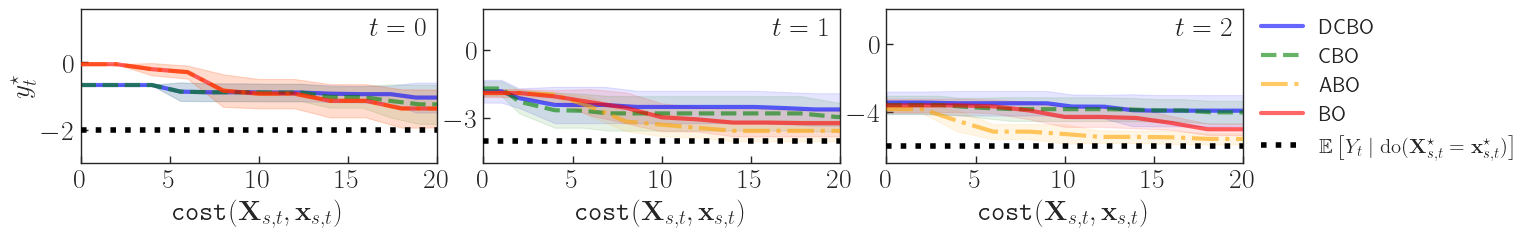

In [27]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,2))